# Identification of Barriers to Mental Health Treatment
#### Created by: Chao Wang, 7/24/2021

## Introduction

Mental health problems are of high prevalence and burden in the workplace, but many people don't feel comfortable discussing their mental health issues and do not seek professional treatment. 

I am interested in investigating what are the key factors that prevent people from seeking mental health treatment. Using the dataset from the Survey on Mental Health in the Tech Workspace in 2014, I conducted univariate and ML-based multivariate analyses to study this question. 

Below is the outline of my analyses:
1. Import libraries and load data
2. Data preparation
    * Drop unneeded columns
    * Deal with null values
    * Clean data entries
    * Create a test set
3. Exploratory data analysis
    * Check target variable
    * Examine correlations
4. Machine learning-based analysis
    * Data encoding
    * Train and test a Random Forest model
    * Evaluate feature importance
5. Summary

## 1. Import libraries and load data

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [2]:
# Load data
df = pd.read_csv('./archive/survey.csv')

In [3]:
# Review data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

## 2. Data preparation

### Drop unneeded columns

In [4]:
# Drop the variable "comments" because 87% are null values 
df = df.drop(['comments'], axis=1)
# Drop the variable "Timestamp" because it is not relevant to our question
df = df.drop(['Timestamp'],axis=1)

In [5]:
# Check the number of samples in each "state" 
print(df['state'].value_counts())

CA    138
WA     70
NY     57
TN     45
TX     44
OH     30
PA     29
IL     29
OR     29
IN     27
MI     22
MN     21
MA     20
FL     15
VA     14
NC     14
WI     12
MO     12
GA     12
UT     11
CO      9
AL      8
MD      8
AZ      7
NJ      6
OK      6
SC      5
KY      5
CT      4
DC      4
IA      4
SD      3
KS      3
VT      3
NH      3
NV      3
NM      2
WY      2
NE      2
MS      1
ME      1
RI      1
LA      1
ID      1
WV      1
Name: state, dtype: int64


In [6]:
# Because many states contain very few samples, the statistical power is low. So I decided to drop the "state" column. 
df = df.drop(['state'],axis=1)

### Deal with null values

In [7]:
# From df.info(), we know that the "self_employed" column contains 18 (1%) null values
print(df['self_employed'].unique())
print(df['self_employed'].value_counts())

[nan 'Yes' 'No']
No     1095
Yes     146
Name: self_employed, dtype: int64


In [8]:
# Because most responders were not self-employed (1095/(1095+146) = 88%) and there is only 1% null values, let's imputed all the null values with 'No'
df['self_employed'].fillna('No',inplace = True)

In [9]:
# We also know that the "work_interfere" column contains 264 (21%) null values
print(df['work_interfere'].unique())
print(df['work_interfere'].value_counts())

['Often' 'Rarely' 'Never' 'Sometimes' nan]
Sometimes    465
Never        213
Rarely       173
Often        144
Name: work_interfere, dtype: int64


In [10]:
# The "work_interfere" question is the following:
# "If you have a mental health condition, do you feel that it interferes with your work?"
# The null values came from people who answered "NA" to this question.
# From this question we can deduce that anyone who answered other than "NA" must have a mental health condition. 
# Because my research quesiton focuses on people with mental health problems, let's drop the participants who responded "NA" to the "work_interfere" question
df.dropna(axis='rows',subset=['work_interfere'],inplace = True)

In [11]:
# Confirm no null values. Note that all 995 participants here have a mental health condition. 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 995 entries, 0 to 1258
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        995 non-null    int64 
 1   Gender                     995 non-null    object
 2   Country                    995 non-null    object
 3   self_employed              995 non-null    object
 4   family_history             995 non-null    object
 5   treatment                  995 non-null    object
 6   work_interfere             995 non-null    object
 7   no_employees               995 non-null    object
 8   remote_work                995 non-null    object
 9   tech_company               995 non-null    object
 10  benefits                   995 non-null    object
 11  care_options               995 non-null    object
 12  wellness_program           995 non-null    object
 13  seek_help                  995 non-null    object
 14  anonymity

### Clean data entries

In [12]:
# Show unique values for all features
for feature in df:
    print(feature, df[feature].unique())

Age [         37          44          32          31          33          35
          39          42          23          29          36          27
          46          41          34          30          40          24
          18          38          26          22          28          25
          45          21          19          43          56          54
         329          55 99999999999          57          58          48
          47          62          51          50          49          20
       -1726          53          61           8          11          -1
          72          60]
Gender ['Female' 'M' 'Male' 'male' 'female' 'm' 'Male-ish' 'Trans-female'
 'Cis Female' 'F' 'Cis Male' 'f' 'Mal' 'queer/she/they' 'non-binary'
 'woman' 'Make' 'Nah' 'All' 'Enby' 'fluid' 'Genderqueer' 'Female '
 'Androgyne' 'Agender' 'cis-female/femme' 'Guy (-ish) ^_^'
 'male leaning androgynous' 'Male ' 'Trans woman' 'msle' 'Neuter'
 'Female (trans)' 'queer' 'Female (cis)' 'Mail' 'ci

In [13]:
# We can see that several age values are not in a reasonalbe range
# Let's replace the out-of-range values with the median age of the group
median_age = df['Age'].median()
df['Age'].replace(to_replace = df[(df['Age'] < 18) | (df['Age'] > 75)]['Age'].tolist(), value = median_age, inplace = True)

In [14]:
# Cut age into ranges for easy analysis, given that all other variables are categorical
df['Age_range'] = pd.cut(df['Age'],[18,25,35,45,55,75], labels = ["18-25","25-35","35-45","45-55","55-75"],include_lowest=True)
df = df.drop(['Age'], axis=1)

In [15]:
# Clean "Gender"
male_list = ['Male ', 'male', 'M', 'm', 'Male', 'Cis Male',
                     'Man', 'cis male', 'Mail', 'Male-ish', 'Male (CIS)',
                      'Cis Man', 'msle', 'Malr', 'Mal', 'maile', 'Make']
female_list = ['Female ', 'female', 'F', 'f', 'Woman', 'Female',
                     'femail', 'Cis Female', 'cis-female/femme', 'Femake', 'Female (cis)',
                     'woman']
other_list = ['Female (trans)', 'queer/she/they', 'non-binary',
                     'fluid', 'queer', 'Androgyne', 'Trans-female', 'male leaning androgynous',
                      'Agender', 'A little about you', 'Nah', 'All',
                      'ostensibly male, unsure what that really means',
                      'Genderqueer', 'Enby', 'p', 'Neuter', 'something kinda male?',
                      'Guy (-ish) ^_^', 'Trans woman']
df['Gender'].replace(to_replace = male_list, value = 'Male',inplace = True)
df['Gender'].replace(to_replace = female_list, value = 'Female',inplace = True)
df['Gender'].replace(to_replace = other_list, value = 'Other',inplace = True)

In [16]:
# Check number of samples in each country
df['Country'].value_counts()

United States             607
United Kingdom            141
Canada                     63
Germany                    33
Ireland                    23
Australia                  20
Netherlands                19
New Zealand                 8
Poland                      7
Italy                       6
South Africa                5
India                       5
Switzerland                 5
Sweden                      5
Belgium                     4
Brazil                      4
France                      4
Singapore                   4
Bulgaria                    3
Israel                      3
Denmark                     2
Russia                      2
Mexico                      2
Croatia                     2
Finland                     2
Colombia                    2
Thailand                    1
Georgia                     1
Slovenia                    1
Philippines                 1
Czech Republic              1
Zimbabwe                    1
Austria                     1
Bosnia and

In [17]:
# Combine all the countries with a sample size < 60 into one categorty, labeled as "Other"
df['Country'].replace(to_replace = ['Bulgaria', 'Netherlands',
 'Poland', 'Australia', 'France', 'Germany', 'Mexico', 'Brazil', 'Slovenia',
 'Ireland', 'India', 'South Africa', 'Russia', 'Italy', 'Colombia', 'Portugal',
 'Switzerland', 'Belgium', 'Sweden', 'New Zealand', 'Zimbabwe', 'Finland',
 'Israel', 'Bosnia and Herzegovina', 'Austria', 'Hungary', 'Singapore', 'Japan',
 'Croatia', 'Thailand', 'Denmark', 'Bahamas, The', 'Moldova', 'Georgia', 'China',
 'Czech Republic', 'Philippines'], value = 'Other',inplace = True)

In [18]:
# Now let's review the data again
for feature in df:
    print(feature, df[feature].unique())

Gender ['Female' 'Male' 'Other']
Country ['United States' 'Canada' 'United Kingdom' 'Other']
self_employed ['No' 'Yes']
family_history ['No' 'Yes']
treatment ['Yes' 'No']
work_interfere ['Often' 'Rarely' 'Never' 'Sometimes']
no_employees ['6-25' 'More than 1000' '26-100' '100-500' '1-5' '500-1000']
remote_work ['No' 'Yes']
tech_company ['Yes' 'No']
benefits ['Yes' "Don't know" 'No']
care_options ['Not sure' 'No' 'Yes']
wellness_program ['No' "Don't know" 'Yes']
seek_help ['Yes' "Don't know" 'No']
anonymity ['Yes' "Don't know" 'No']
leave ['Somewhat easy' "Don't know" 'Somewhat difficult' 'Very difficult'
 'Very easy']
mental_health_consequence ['No' 'Maybe' 'Yes']
phys_health_consequence ['No' 'Yes' 'Maybe']
coworkers ['Some of them' 'No' 'Yes']
supervisor ['Yes' 'No' 'Some of them']
mental_health_interview ['No' 'Yes' 'Maybe']
phys_health_interview ['Maybe' 'No' 'Yes']
mental_vs_physical ['Yes' "Don't know" 'No']
obs_consequence ['No' 'Yes']
Age_range [35-45, 25-35, 18-25, 45-55, 55-7

### Create a test set
Set aside part of the data for testing. This step should be performed before any exploratory analysis to avoid potential selective bias. 

In [19]:
# Perform stratified train-test split
ss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
X = df.drop(['treatment'],axis=1)
for train_index, test_index in ss.split(X, df['treatment']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

## 3. Exploratory data analysis

### Check target variable

Text(0.5, 1.0, 'Have sought treatment for a mental health condition?')

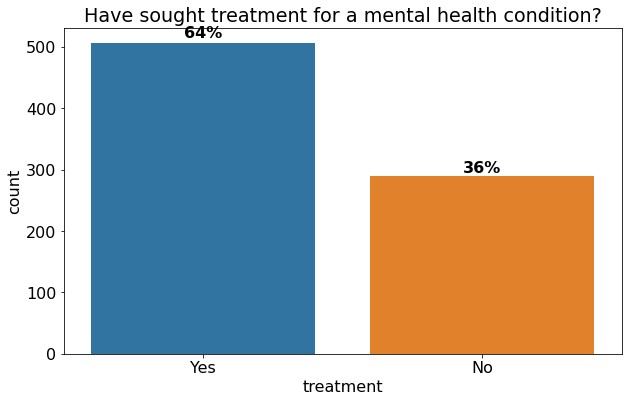

In [20]:
# Let's first check the target variable "treatment"
mpl.rcParams['font.size'] = 16
plt.figure(figsize=(10,6))
ax = sns.countplot(x="treatment", data=train_df)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

plt.title('Have sought treatment for a mental health condition?')

We can see that among the participants who have a mental health condition, 64% of them have sought treatment and 36% have not. 
The main aim of this analysis is to understand what are the factors that influence people's decison on whether or not to seek treatment.

### Examine correlations
Because that the data are categorical, Pearson's or Spearman's correlation is not suitable to apply. I use a metric called Cramer's V, which is based on a nominal variation of Pearson's Chi-Square test.

In [21]:
# Function to compute Cramer's V 
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

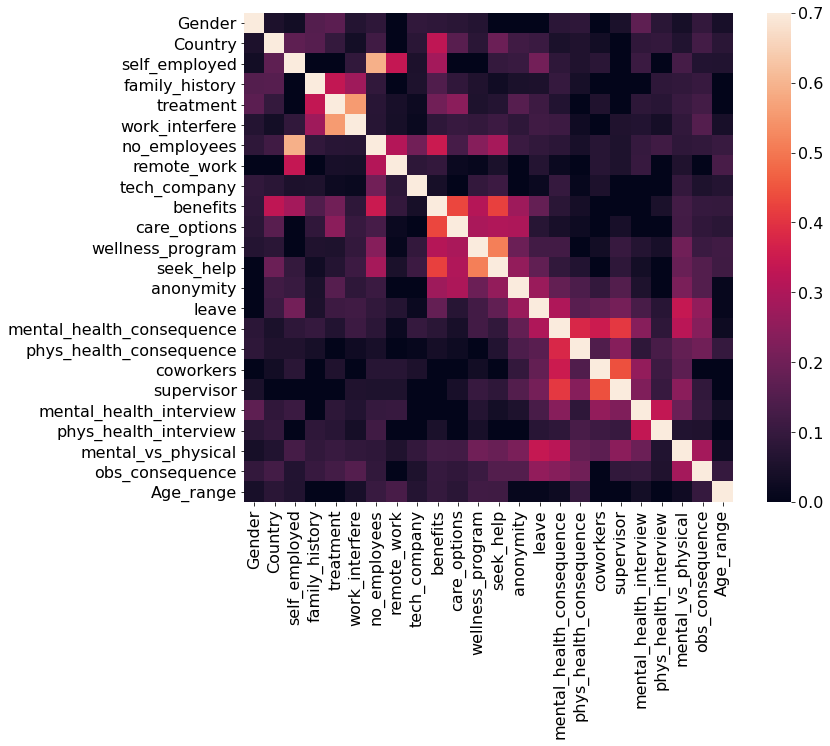

In [22]:
# Compute and plot correlation matrix
n_col = len(train_df.columns)
corr_matrix = np.empty([n_col,n_col])
for i in range(n_col):
    for j in range(n_col):
        corr_matrix[i,j] = cramers_v(train_df.iloc[:,i],train_df.iloc[:,j])
# Plot heatmap
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, vmax=.7, square=True, xticklabels = train_df.columns, yticklabels = train_df.columns);

In [23]:
# Identify the feature pairs with high correlation
index_pairs = np.argwhere((corr_matrix > 0.4) & (corr_matrix < 0.99))
for i,j in index_pairs:
    if i > j:
        print('corr = ', '{:.2f}'.format(corr_matrix[i][j]), '    ', train_df.columns[i], '   ', train_df.columns[j])

corr =  0.56      work_interfere     treatment
corr =  0.59      no_employees     self_employed
corr =  0.43      care_options     benefits
corr =  0.42      seek_help     benefits
corr =  0.51      seek_help     wellness_program
corr =  0.41      supervisor     mental_health_consequence
corr =  0.44      supervisor     coworkers


The identified pairs of features with high correlation make sense. Note that no correlation exceeding 0.6, suggesting that there is not much redundency in our feature space. 

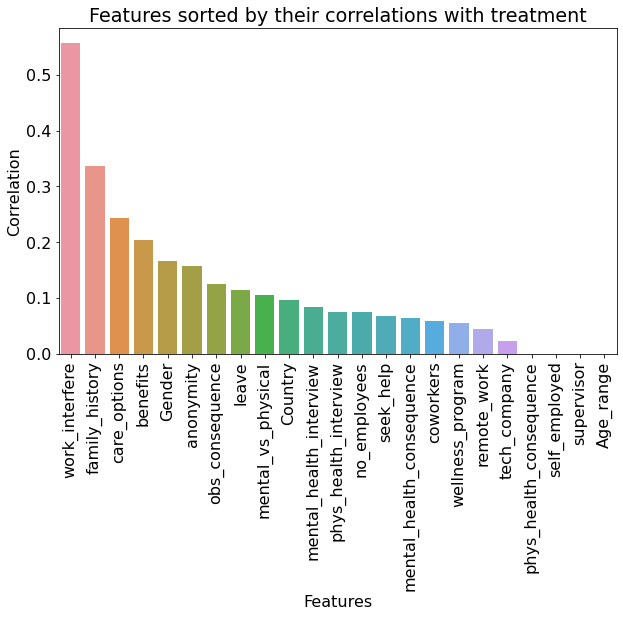

In [24]:
# Sort features by its correlation with "treatment"
fig,ax = plt.subplots(figsize=(10,6))
corr_treatment = corr_matrix[4,:]
i_sort = np.flip(np.argsort(corr_treatment))[1:]
sns.barplot(x=train_df.columns[i_sort],y=corr_treatment[i_sort],ax=ax)
plt.title('Features sorted by their correlations with treatment')
plt.xlabel('Features')
plt.ylabel('Correlation')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)

The top 5 features that are associated with "teatment" are "work_interfere", "family_history", "care_options", "benefits", and "Gender"

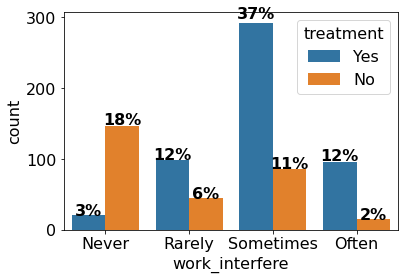

In [25]:
# Barplot grouped by "work_interfere" and "treatment"
ax = sns.countplot(x='work_interfere', hue='treatment', data=train_df, order = ['Never','Rarely','Sometimes','Often'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

It is clear that the more frequently a mental health condition interferes with work, the more likely a person has sought treatment. 

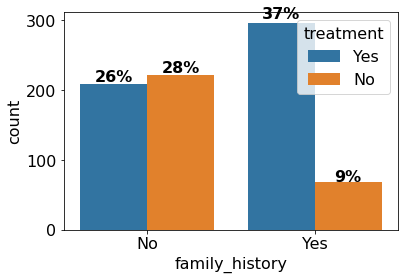

In [26]:
# Barplot grouped by "family_history" and "treatment"
ax = sns.countplot(x='family_history', hue='treatment', data=train_df, order = ['No','Yes'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

People with a family history of mental illness are more likely to seek treatment.

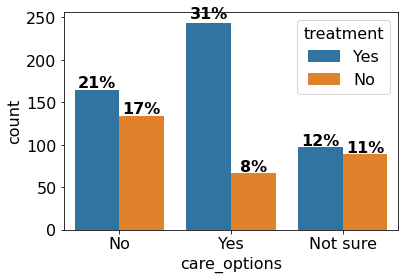

In [27]:
# Barplot grouped by "care_options" and "treatment"
ax = sns.countplot(x='care_options', hue='treatment', data=train_df, order = ['No','Yes','Not sure'])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

People who know the options for mental health care their employers provide are more likely to seek treatment. 

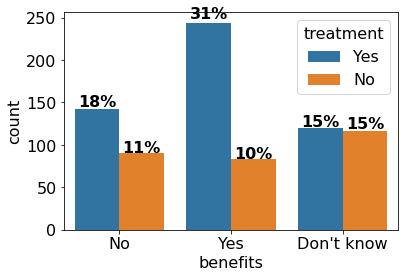

In [28]:
# Barplot grouped by "benefits" and "treatment"
ax = sns.countplot(x='benefits', hue='treatment', data=train_df, order = ['No','Yes',"Don't know"])
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

Similar to the "care_options", people who know their employers provide mental health benefits are more likely to seek treatment.

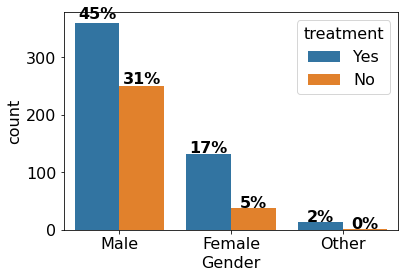

In [29]:
# Barplot grouped by "Gender" and "treatment"
ax = sns.countplot(x='Gender', hue='treatment', data=train_df)
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    percent = height/len(train_df)
    x, y = p.get_xy() 
    ax.annotate(f'{percent:.0%}', (x + width/2, y + height*1.02), ha='center', fontweight='bold')

About 77% of female who have a mental health condition have sought treatment. This number is higher than the pencentage in men (59%).

## 4. Machine learning-based analysis
The task here is to build classification models to predict the "treatment" vairable. Given that the data are categorical and we want to evalute feature importance, I choose to develop decision-tree based models. 

### Data encoding
Here I use OrdinalEncoder to convert labels into numbers. I choose OrdinalEncoder rather than OneHotEncoder because it works better for tree-based models. OneHotEncoder will enlarge feature space and induce sparsity into the dataset which is undesirable. It will also obscure the order of importance of features.

In [30]:
train_X = train_df.drop(['treatment'], axis=1)
train_y = train_df['treatment']
# Encode non-target variables. Make sure that the encoding is in the correct order
X_order = [
    ['Male', 'Female', 'Other'],
    ['United States', 'Canada', 'United Kingdom', 'Other'],
    ['No', 'Yes'],
    ['No', 'Yes'],
    ['Never', 'Rarely', 'Sometimes', 'Often'],
    ['1-5', '6-25', '26-100', '100-500', '500-1000', 'More than 1000'],
    ['No', 'Yes'],
    ['No', 'Yes'],
    ['No', "Don't know", 'Yes'],
    ['No', 'Not sure', 'Yes'],
    ['No', "Don't know", 'Yes'],
    ['No', "Don't know", 'Yes'],
    ['No', "Don't know", 'Yes'],
    ['Very easy', 'Somewhat easy', 'Somewhat difficult', 'Very difficult', "Don't know" ],
    ['No', 'Maybe', 'Yes'],
    ['No', 'Maybe', 'Yes'],
    ['No', 'Some of them','Yes'],
    ['No', 'Some of them', 'Yes'],
    ['No', 'Maybe', 'Yes'],
    ['No', 'Maybe', 'Yes'],
    ['No', "Don't know",'Yes'],
    ['No', 'Yes'],
    ['18-25','25-35','35-45','45-55','55-75']]
ordinal_encoder = OrdinalEncoder(categories=X_order)
train_X_encoded = ordinal_encoder.fit_transform(train_X)
# Encode target variable
label_encoder = LabelEncoder()
train_y_encoded = label_encoder.fit_transform(train_y)

### Train and test a Random Forest model

In [31]:
forest = RandomForestClassifier(random_state=42, class_weight='balanced')
# Hyperparameter tuning using grid search with cross-validation
param_grid = {
    'n_estimators': [200], 
    'max_features':[4,5],
    'bootstrap':[True,False],
    'max_depth': [5,7,9],
    'min_samples_split':[5,10,15]
}
param_search = GridSearchCV(forest,param_grid, cv=5,
                                 scoring='accuracy',
                                 return_train_score=True)
param_search.fit(train_X_encoded, train_y_encoded)
# Print the best set of parameter
print(param_search.best_estimator_)

RandomForestClassifier(class_weight='balanced', max_depth=7, max_features=4,
                       min_samples_split=10, n_estimators=200, random_state=42)


In [32]:
# Evaluate model performance on the training set
rf_model = param_search.best_estimator_
train_y_predicted = rf_model.predict(train_X_encoded)
target_names = ['No','Yes']
print(metrics.classification_report(train_y_encoded,train_y_predicted, target_names=target_names))

              precision    recall  f1-score   support

          No       0.81      0.81      0.81       290
         Yes       0.89      0.89      0.89       506

    accuracy                           0.86       796
   macro avg       0.85      0.85      0.85       796
weighted avg       0.86      0.86      0.86       796



In [33]:
# Encode model performance on the test set
# Enocode test data
test_X = test_df.drop(['treatment'], axis=1)
test_y = test_df['treatment']
test_X_encoded = ordinal_encoder.transform(test_X)
test_y_encoded = label_encoder.transform(test_y)

# Test performance
test_y_predicted = rf_model.predict(test_X_encoded)
print(metrics.classification_report(test_y_encoded,test_y_predicted, target_names=target_names))

              precision    recall  f1-score   support

          No       0.70      0.65      0.68        72
         Yes       0.81      0.84      0.83       127

    accuracy                           0.77       199
   macro avg       0.76      0.75      0.75       199
weighted avg       0.77      0.77      0.77       199



Using the random forest model, we reached 77% accuracy in predicting which individuals have sought mental health treatment. 
Note that the training accuracy (86%) is significantly higher than the testing accuracy (77%), suggesting that we have an overfitted model. However, it is not a concern because that the hyperparamters are optimaized through cross-validation.

### Evaluate feature importance

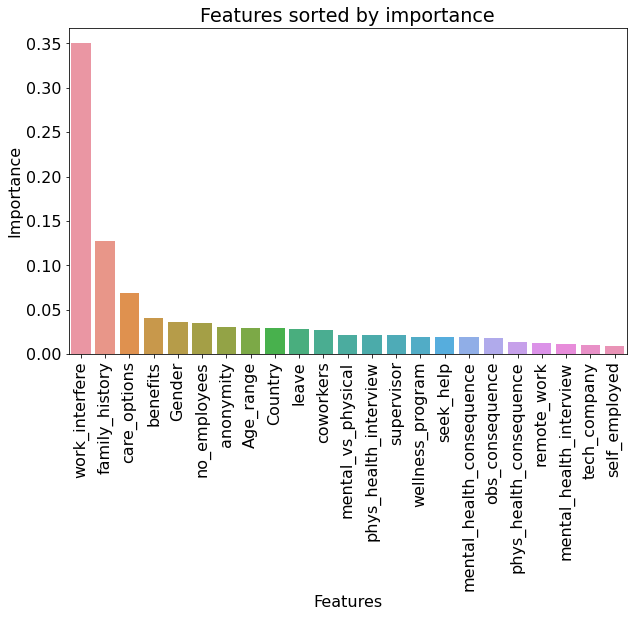

In [34]:
# Feature importance, which is based on how much the tree nodes that use that feature reduce impurity on average
fi_score = rf_model.feature_importances_
# Plot features scored by importance
fig,ax = plt.subplots(figsize=(10,6))
rf_score = rf_model.feature_importances_
i_sort = np.flip(np.argsort(rf_score))[0:]
sns.barplot(x=train_X.columns[i_sort],y=rf_score[i_sort],ax=ax)
plt.title('Features sorted by importance')
plt.xlabel('Features')
plt.ylabel('Importance')
ticks = plt.setp(ax.get_xticklabels(),rotation=90)

The top 5 important features are "work_interfere", "family_history", "care_options", "benefits", and "Gender", which are consistent with what we found from the correlation analysis. 

## 5. Summary

Among workers with mental health problems, the strongest predictors of who have sought mental health treatment ("treatment") are: 
1. how frequently the mental health condition interferes with work ("work_interfere")
2. whether the person has a famility history of mental illness ("family_history")
3. whether the person knows the employer-provided care options ("care_options")
4. whether the person's employer provides mental health benefits ("benefits")
5. gender ("Gender")

**The results suggest that low perceived work interference is the most common reason for not initiating treatment. People with family history of mental illness and women are more likely to recognize a need for treatement. The lack of employer-provided mental health benefits and don't know the employer-provided care options are two barriers to initiating mental health treatment.**

Suprisingly, "treatment" is less predicted by the answers to the attitude-related questions, such as "Would you bring up a mental health issue with a potential employer in an interview?" and "Would you be willing to discuss a mental health issue with your coworkers and supervisor?" It suggests that "willingness to discuss a mental health issue" and "willingness to seek treatment" are probably less correlated than we think. 